### "Amazon-Alexa" Topic modeling with Gensim

#### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

### import the required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

### Load the input data ( "amazon alexa reviews data")

In [9]:
# Loading TSV file
df_amazon = pd.read_csv ("/content/sample_data/amazon_alexa.tsv", sep="\t")

In [10]:
# Top 5 records
df_amazon.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [11]:
df_amazon_mod = df_amazon[['verified_reviews','feedback']]
df_amazon_mod.head()

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [12]:
import re
def clean(string):
    string = str(string)
    cleanString = re.sub('[^A-Za-z]+',' ', string )
    return cleanString

df_amazon_mod['reviews_non_numeric'] = df_amazon_mod['verified_reviews'].map(clean)
df_amazon_mod['reviews_len_trim'] = df_amazon_mod['reviews_non_numeric'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df_amazon_mod['reviews_Tokenized'] = df_amazon_mod['reviews_len_trim'].map(lambda x: x.lower().split())
df_amazon_mod['reviews_Tokenized_stop'] = df_amazon_mod['reviews_Tokenized'].map(lambda x: " ".join(x for x in x if x not in stop_words))
df_amazon_mod['reviews_Tokenized_stop'] = df_amazon_mod['reviews_Tokenized_stop'].map(lambda x: x.split())

<ipython-input-12-8bc305872628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amazon_mod['reviews_non_numeric'] = df_amazon_mod['verified_reviews'].map(clean)
<ipython-input-12-8bc305872628>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amazon_mod['reviews_len_trim'] = df_amazon_mod['reviews_non_numeric'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


In [13]:
df_amazon_mod.head()

,verified_reviews,feedback,reviews_non_numeric,reviews_len_trim,reviews_Tokenized,reviews_Tokenized_stop
0,Love my Echo!,1,Love my Echo,Love Echo,"[love, echo]","[love, echo]"
1,Loved it!,1,Loved it,Loved,[loved],[loved]
2,"Sometimes while playing a game, you can answer...",1,Sometimes while playing a game you can answer ...,Sometimes while playing game you can answer qu...,"[sometimes, while, playing, game, you, can, an...","[sometimes, playing, game, answer, question, c..."
3,I have had a lot of fun with this thing. My 4 ...,1,I have had a lot of fun with this thing My yr ...,have had lot fun with this thing old learns ab...,"[have, had, lot, fun, with, this, thing, old, ...","[lot, fun, thing, old, learns, dinosaurs, cont..."
4,Music,1,Music,Music,[music],[music]


In [14]:
df_amazon_mod['reviews_Tokenized_stop'][0:3]

0                                         [love, echo]
1                                              [loved]
2    [sometimes, playing, game, answer, question, c...
Name: reviews_Tokenized_stop, dtype: object

In [15]:
# Create a corpus from a list of texts 

texts = df_amazon_mod['reviews_Tokenized_stop']

# 1. Create Dictionary ( constructs word -> id mapping )
id2word = corpora.Dictionary(df_amazon_mod['reviews_Tokenized_stop'])

# Term Document Frequency ( convert document into the bag of words )
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [16]:
id2word[0]

'echo'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('echo', 1), ('love', 1)]]

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # bow representation of docs
                                           id2word=id2word, # dictionary ( word -> id mapping )
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1, # number of docs to be iterated through for each update
                                           chunksize=100, # number of documents to be used in each training chunk
                                           passes=10, # number of passes through the corpus during training
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
print(*lda_model.print_topics(), sep='\n\n')
doc_lda = lda_model[corpus]

(0, '0.056*"house" + 0.048*"work" + 0.039*"questions" + 0.032*"connected" + 0.024*"volume" + 0.023*"wanted" + 0.020*"computer" + 0.020*"convenient" + 0.019*"working" + 0.019*"trying"')

(1, '0.172*"great" + 0.099*"works" + 0.066*"good" + 0.063*"product" + 0.051*"speaker" + 0.025*"sound" + 0.023*"another" + 0.020*"wish" + 0.018*"kids" + 0.018*"perfect"')

(2, '0.159*"echo" + 0.102*"dot" + 0.047*"better" + 0.046*"sound" + 0.041*"quality" + 0.025*"purchase" + 0.021*"phone" + 0.019*"speaker" + 0.015*"size" + 0.014*"dots"')

(3, '0.053*"music" + 0.050*"alexa" + 0.042*"like" + 0.027*"one" + 0.026*"play" + 0.021*"home" + 0.018*"time" + 0.018*"get" + 0.017*"amazon" + 0.017*"smart"')

(4, '0.040*"fine" + 0.035*"light" + 0.028*"loved" + 0.025*"additional" + 0.024*"bulbs" + 0.023*"disappointed" + 0.020*"hooked" + 0.018*"next" + 0.016*"thermostat" + 0.016*"error"')

(5, '0.185*"love" + 0.102*"use" + 0.044*"still" + 0.027*"got" + 0.026*"everything" + 0.026*"much" + 0.025*"fun" + 0.023*"far" + 0.023

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_amazon_mod['reviews_Tokenized_stop'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.546279505100364

Coherence Score:  0.43346069035334167


### LDA Mallet Model

In [ ]:
mallet_path = '/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [27]:

!pip install gensim
from gensim import corpora
from gensim.models.wrappers import LdaMallet

mallet_path = '//content/sample_data/mallet'  # Update with the path to your MALLET installation
num_topics = 20

# Convert corpus to MALLET format
corpus_path = 'corpus.mallet'
corpora.MalletCorpus.serialize(corpus_path, corpus, id2word=id2word)

# Train LDA model using MALLET
ldamallet = LdaMallet(mallet_path, corpus=corpus_path, num_topics=num_topics, id2word=id2word)

# Print topics and their top words
pprint(ldamallet.show_topics())

# Clean up temporary corpus file
import os
os.remove(corpus_path)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ModuleNotFoundError: ignored

In [ ]:
#Show Topics
print(*ldamallet.show_topics(formatted=False),sep='\n\n')

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df_amazon_mod['reviews_Tokenized_stop'], dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

(6, [('music', 0.09603760913364674), ('nice', 0.06581598388179986), ('listen', 0.05439892545332438), ('playing', 0.04701141705842848), ('features', 0.039623908663532575), ('questions', 0.036937541974479515), ('price', 0.03492276695768973), ('money', 0.03022162525184688), ('understand', 0.026863666890530557), ('worth', 0.026192075218267292)])

(2, [('make', 0.04445964432284542), ('times', 0.038303693570451436), ('hear', 0.03419972640218878), ('find', 0.03283173734610123), ('commands', 0.030779753761969904), ('simple', 0.028727770177838577), ('made', 0.0280437756497948), ('instructions', 0.0253077975376197), ('part', 0.023939808481532147), ('amazing', 0.023255813953488372)])

(11, [('home', 0.15390070921985816), ('smart', 0.12907801418439716), ('purchase', 0.058865248226950356), ('google', 0.0375886524822695), ('happy', 0.03546099290780142), ('amazing', 0.031205673758865248), ('add', 0.027659574468085105), ('skills', 0.023404255319148935), ('enjoying', 0.01773049645390071), ('adding', 0.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_amazon_mod['reviews_Tokenized_stop'], start=2, limit=40, step=6)

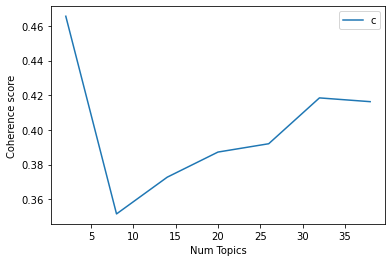

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4656
Num Topics = 8  has Coherence Value of 0.3515
Num Topics = 14  has Coherence Value of 0.3728
Num Topics = 20  has Coherence Value of 0.3872
Num Topics = 26  has Coherence Value of 0.392
Num Topics = 32  has Coherence Value of 0.4185
Num Topics = 38  has Coherence Value of 0.4163


In [ ]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
print(*optimal_model.print_topics(num_words=10),sep='\n\n\n')



(0, '0.057*"echo" + 0.036*"music" + 0.023*"sound" + 0.021*"great" + 0.019*"dot" + 0.019*"good" + 0.017*"amazon" + 0.016*"speaker" + 0.015*"home" + 0.014*"device"')


(1, '0.065*"love" + 0.043*"alexa" + 0.028*"great" + 0.026*"works" + 0.023*"easy" + 0.021*"set" + 0.017*"product" + 0.015*"play" + 0.013*"time" + 0.013*"bought"')


### Finding the dominant topic in each sentence
### Finding the most representative document for each topic
### Topic distributions across documents

### Topic Modeling - LSA model

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df_amazon_mod['reviews_Tokenized_stop'])

# Create Corpus
texts = df_amazon_mod['reviews_Tokenized_stop']

# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [ ]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

# find the coherence score with a different number of topics
for i in range(2,11):
    lsi = LsiModel(corpus, num_topics=i, id2word=id2word)
    coherence_model = CoherenceModel(model=lsi, texts=df_amazon_mod['reviews_Tokenized_stop'], dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.5677718361141961
Coherence score with 3 clusters: 0.4641725797070415
Coherence score with 4 clusters: 0.5130457412757761
Coherence score with 5 clusters: 0.4651322304028655
Coherence score with 6 clusters: 0.5288331032928134
Coherence score with 7 clusters: 0.5589591871100653
Coherence score with 8 clusters: 0.4937608935922796
Coherence score with 9 clusters: 0.5349721609036857
Coherence score with 10 clusters: 0.5828032705573989


In [ ]:
### The coherence score is highest with 10 topics

In [ ]:
# perform SVD on the bag of words with the LsiModel to extract 2 topics
lsi = LsiModel(corpus, num_topics=2, id2word=id2word)

In [ ]:
# find the 5 words with the srongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=5):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.474*"echo" + 0.313*"alexa" + 0.265*"love" + 0.214*"music" + 0.202*"great".
Words in 1: 0.676*"echo" + -0.332*"alexa" + -0.323*"love" + -0.218*"music" + 0.174*"hub".
